In [76]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from tools import gen_linear, display_graph,display_tab, plot_data, gen_arti, plot_frontiere

In [77]:
data = pd.read_csv('data/classificationA.train', sep='\t', header=None)

In [78]:
X = data.values[:,0:2]
y = data.values[:,2]

Text(0.5, 1.0, 'Donnees')

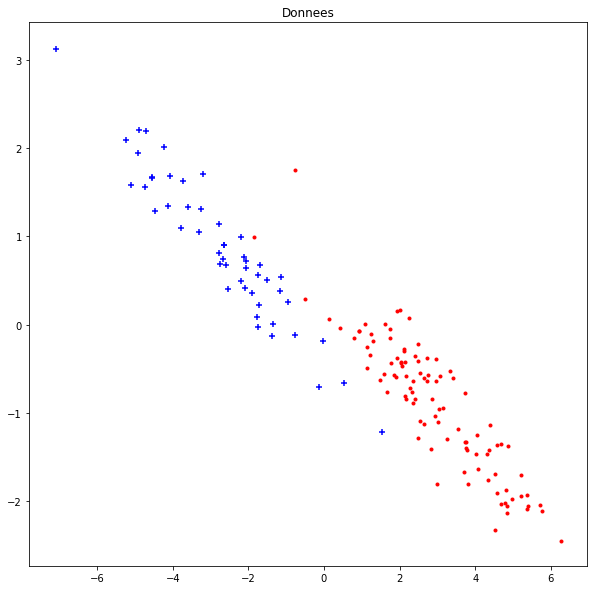

In [79]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.ion()
plt.figure(figsize=(10,10))
plot_data(X,y)
plt.title('Donnees')


# Generative Model(LDA)

In [80]:
class LDA():
    def fit(self,X,y):
        n = y.shape[0]
        Ny = np.sum(y==0)
        
        pi = Ny/n
        
        mu0 = np.sum(X[y==0],axis=0)/(Ny)
        mu1 = np.sum(X[y==1],axis=0)/(n-Ny)
        
        sigma = ((X[y==0]-mu0).T.dot((X[y==0]-mu0))+(X[y==1]-mu1).T.dot((X[y==1]-mu1)))/n
        
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma = sigma
        self.pi = pi
        self.sigma_inv = np.linalg.inv(self.sigma)
        
        return  mu0, mu1, sigma

    def predict_proba(self,X):
        
        if X.ndim != 1:
            p0 = self.pi*np.exp(np.apply_along_axis(lambda x:(x-self.mu0).dot(self.sigma_inv).dot((x-self.mu0).T), arr=X, axis=1))
            p1 = (1-self.pi)*np.exp(np.apply_along_axis(lambda x:(x-self.mu1).dot(self.sigma_inv).dot((x-self.mu1).T), arr=X, axis=1))
            p0 = p0/(p0+p1)
        else:
            p0 = self.pi*np.exp(X-self.mu0).dot(self.sigma_inv).dot((X-self.mu0).T)
            p1 = (1-self.pi)*np.exp(X-self.mu1).dot(self.sigma_inv).dot((X-self.mu1).T)
            p0 = p0/(p0+p1)
        
        return p0

    def predict(self,X):
        return self.predict_proba(X)>0.5


In [81]:
lda=LDA()
lda.fit(X,y)

(array([ 2.89970947, -0.893874  ]),
 array([-2.69232004,  0.866042  ]),
 array([[ 2.44190897, -1.13194024],
        [-1.13194024,  0.61375465]]))

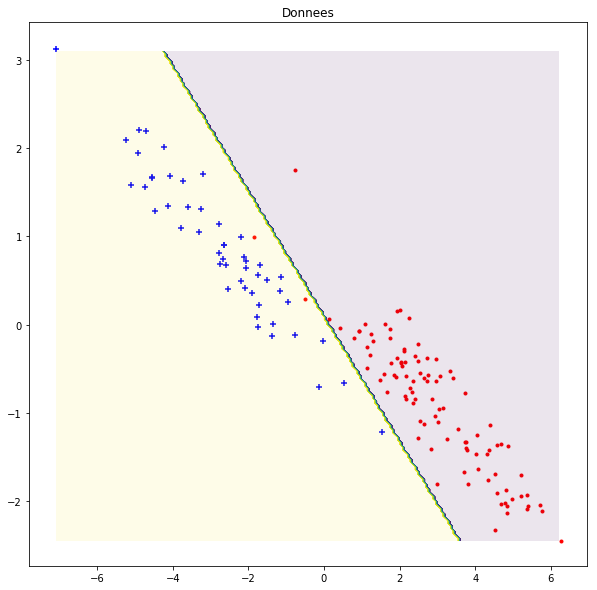

In [82]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(10,10))
plot_data(X,y)
plt.title('Donnees')
plot_frontiere(X,lda.predict, alpha_c=0.1,step=200)

# Linear Regression

In [83]:
class LinearRegression():
    def fit(self,X,Y):
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y) 
        self.w = w 
        return w

    def predict_proba(self,X, w=None):
        if w is None:
            w = self.w
        #we add a colon of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==w.shape[0])

        return X.dot(w)

    def predict(self,X, w=None):
        if w is None:
            w = self.w
        return self.predict_proba(X,w)>0.5


In [84]:
lin = LinearRegression()
lin.fit(X,y)
y_pred = lin.predict(X)

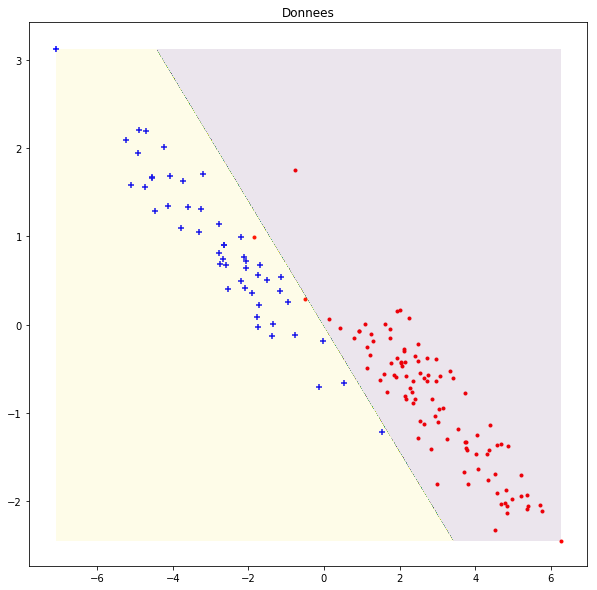

In [85]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(10,10))
plot_data(X,y)
plt.title('Donnees')
plot_frontiere(X,lin.predict, alpha_c=0.1,step=1000)